In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import swing3dify.time_adjustment as ta
from calibration_data import KNOWN_CALIBRATION_DATA

In [2]:
df1 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/red_0712_0016/position_data.csv')
df2 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/white_0712_0016/position_data.csv')

In [3]:
df1.interpolate(method='linear', both=True, inplace=True)
df2.interpolate(method='linear', both=True, inplace=True)

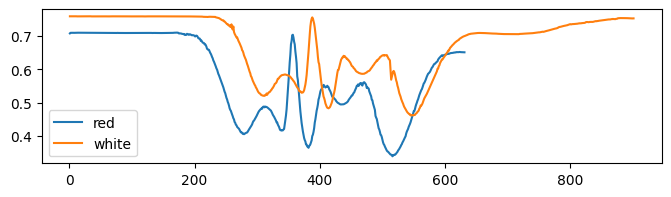

In [4]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(df1['frame'], df1['HOSEL_y'], label='red')
ax.plot(df2['frame'], df2['HOSEL_y'], label='white')
ax.legend()
plt.show()

In [5]:
delay_frame = ta.calculate_delay_frame(df1, df2, 'HOSEL')
print(f'delay_frame: {delay_frame}')

delay_frame: -32


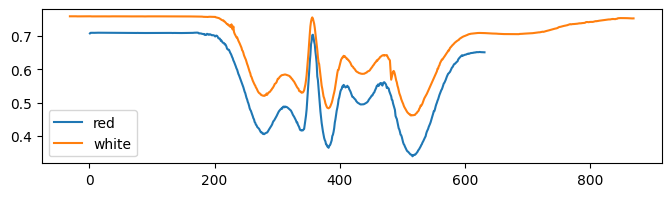

In [6]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(df1['frame'], df1['HOSEL_y'], label='red')
ax.plot(df2['frame'] + delay_frame, df2['HOSEL_y'], label='white')
ax.legend()
plt.show()

In [7]:
img_num = 350

img1 = cv2.imread(f'C:/Users/kitano/3d_reconstruction/data/img/red_0712_0016/red_0712_0016_{img_num}.jpg')
img2 = cv2.imread(f'C:/Users/kitano/3d_reconstruction/data/img/white_0712_0016/white_0712_0016_{img_num - delay_frame}.jpg')

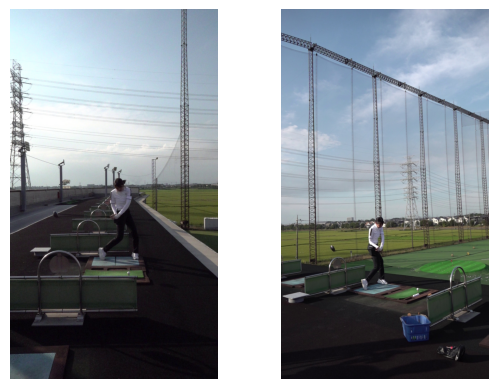

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [10]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

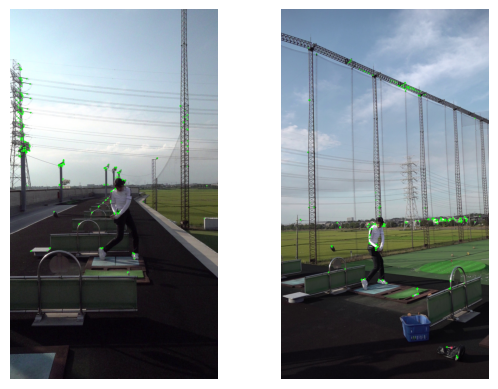

In [12]:
img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0))
img2_with_keypoints = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [24]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

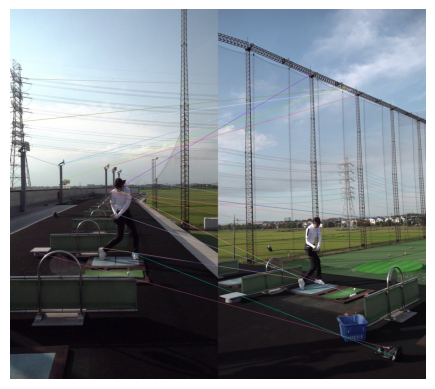

In [16]:
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

In [25]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
mtx = np.array(KNOWN_CALIBRATION_DATA['FDR-AX700']['mtx'])
E = mtx.T.dot(F).dot(mtx)

U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
R = U.dot(W).dot(Vt)
T = U[:, 2]

In [29]:
print(f'Rotation: {R}')
print(f'Translation: {T}')

Rotation: [[-0.08136195 -0.93233909  0.35231244]
 [-0.82810897 -0.13346921 -0.54444605]
 [ 0.5546312  -0.33605028 -0.76121905]]
Translation: [-0.07988873  0.33022112  0.94051677]
